<h1><center>Turkcell Traffic </center></h1>

* Bu çalışmada Turkcell datası, Traditional Channel bazında filtrelenip ardından clustering yapılarak çıktılar alındı.

In [1]:
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

# basic
import os
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
import sklearn
from scipy.special import boxcox1p
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('dark')

In [2]:
bq_client = bigquery.Client()
bq_storage_client = bigquery_storage_v1beta1.BigQueryStorageClient()

sql = """
select * 
from coca-cola-datalake-dev.EXT_POI_STAGE.outlet_turkcell 
where city_name = "İstanbul"
"""

df_new = bq_client.query(sql, location='EU').to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type='tqdm')

Downloading:   0%|          | 0/10351656 [00:00<?, ?rows/s]/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_schema is deprecated as of 0.17.0, please use pyarrow.ipc.read_schema instead
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_record_batch is deprecated as of 0.17.0, please use pyarrow.ipc.read_record_batch instead
  warnings.warn(msg, FutureWarning)
Downloading: 100%|██████████| 10351656/10351656 [00:12<00:00, 797115.65rows/s]


In [3]:
print("Total amount of data: ", len(df_new))

Total amount of data:  10351656


In [4]:
print("Total amount of outlet is:", df_new.outlet_number.nunique())

Total amount of outlet is: 22701


There are 8664 records for each outlet 

In [5]:
# Traditional Channel'ı filtreleyelim.
df = df_new.query("main_channel_text == 'TRADITIONAL RETAIL'").reset_index(drop=True)

In [6]:
df.head(3)

,outlet_number,outlet_main_channel_code,main_channel_text,outlet_sub_trade_channel_code,outlet_sub_trade_channel_text,city_name,district_name,neighbor_name,distance,prob,poi_id,poi_name,poi_category,CALL_MONTH,CALL_WEEKDAY,CALL_HOUR,BODY_COUNT
0,8893659,1,TRADITIONAL RETAIL,112,OTHER SPECIALITYFOOD,İstanbul,Adalar,Heybeliada Mh.,46.524067,0.401312,1940609,Ada Market,Bakkal/Market,March,WEEKEND,H_17,333.125000
1,8893659,1,TRADITIONAL RETAIL,112,OTHER SPECIALITYFOOD,İstanbul,Adalar,Heybeliada Mh.,46.524067,0.401312,1940609,Ada Market,Bakkal/Market,December,WEEKDAY,H_23,190.391304
2,8893659,1,TRADITIONAL RETAIL,112,OTHER SPECIALITYFOOD,İstanbul,Adalar,Heybeliada Mh.,46.524067,0.401312,1940609,Ada Market,Bakkal/Market,June,WEEKDAY,H_18,462.954545


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769776 entries, 0 to 6769775
Data columns (total 17 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   outlet_number                  object 
 1   outlet_main_channel_code       object 
 2   main_channel_text              object 
 3   outlet_sub_trade_channel_code  object 
 4   outlet_sub_trade_channel_text  object 
 5   city_name                      object 
 6   district_name                  object 
 7   neighbor_name                  object 
 8   distance                       float64
 9   prob                           float64
 10  poi_id                         int64  
 11  poi_name                       object 
 12  poi_category                   object 
 13  CALL_MONTH                     object 
 14  CALL_WEEKDAY                   object 
 15  CALL_HOUR                      object 
 16  BODY_COUNT                     float64
dtypes: float64(3), int64(1), object(13)
memory usa

In [8]:
pivot_table = pd.pivot_table(data=df,index=['outlet_number'], columns=['CALL_HOUR'], values=['BODY_COUNT'])

In [9]:
pivot_table

BODY_COUNT                                                  \
CALL_HOUR            H_00        H_06        H_07        H_08        H_09   
outlet_number                                                               
10006358       623.616607  520.444588  585.635929  568.480032  554.117032   
10006376       330.465463  208.025626  288.124834  363.471320  415.324940   
10006447       362.302141  240.306937  347.279345  471.429824  536.390875   
10006456       313.199932  284.071413  340.186302  396.947682  410.287223   
10006518       209.129286  165.687704  284.166153  321.569914  279.932084   
...                   ...         ...         ...         ...         ...   
9928176        170.307165  135.759460  188.632237  206.676372  200.735413   
9928188        213.076792  146.019465  215.677861  266.420938  284.070596   
9928190        423.916869  346.479720  595.859297  779.671337  878.580048   
9928206        249.711613  167.787643  229.499875  297.826193  330.388019   
9928208        286.636357  222.276005  294.405458  346.639268  369.137889   

                                                                               \
CALL_HOUR            H_10         H_11         H_12         H_13         H_14   
outlet_number                                                                   
10006358       593.931996   643.319641   713.678984   766.112038   790.348112   
10006376       476.393901   536.844862   602.046577   651.192998   677.492587   
10006447       583.675478   617.865821   677.603258   709.864935   723.482405   
10006456       439.944401   468.087601   507.712470   546.002659   553.753836   
10006518       298.756063   318.061762   350.048869   363.192806   369.668574   
...                   ...          ...          ...          ...          ...   
9928176        217.256763   239.929827   276.797570   303.275287   307.950531   
9928188        309.841830   338.529708   370.173195   408.757331   420.007492   
9928190        992.600320  1054.003014  1170.588579  1179.557870  1155.213275   
9928206        360.186860   380.976016   416.260313   440.278948   459.800172   
9928208        407.038752   437.369717   473.496118   503.564889   519.270935   

                                                                              \
CALL_HOUR             H_15         H_16         H_17        H_18        H_19   
outlet_number                                                                  
10006358        790.052291   807.161152   827.621312  879.081891  889.410554   
10006376        699.895954   704.704514   696.775354  678.255865  634.746304   
10006447        731.656743   733.576823   719.998764  694.613641  644.747718   
10006456        556.680111   553.353364   543.216996  543.882207  513.951296   
10006518        402.001992   423.919521   451.421972  443.585837  350.226609   
...                    ...          ...          ...         ...         ...   
9928176         311.373690   299.115875   300.407468  309.806049  307.690554   
9928188         426.643947   423.802518   416.804529  422.152190  393.456907   
9928190        1166.366168  1110.398723  1059.309439  954.991095  771.717989   
9928206         465.933370   467.222846   446.509599  427.799234  401.070551   
9928208         519.849264   521.910512   512.038422  511.283932  492.146794   

                                                               
CALL_HOUR            H_20        H_21        H_22        H_23  
outlet_number                                                  
10006358       875.555929  862.591620  833.075864  605.333929  
10006376       578.999087  525.128889  474.646455  315.108464  
10006447       591.459364  546.215124  501.839149  354.046808  
10006456       471.306744  437.244399  408.866641  296.952474  
10006518       312.292017  282.991818  261.398820  187.997898  
...                   ...         ...         ...         ...  
9928176        292.417415  269.952563  249.233876  178.638507  
9928188        371.033956  347.021301  3

In [10]:
table = pivot_table.reset_index(drop=True)

In [11]:
# o row a ait saat bazında yoğunluk percentage'ı bulmak istediğimizden row/total yaparak density df oluşturuyoruz.
density_df = table.div(table.sum(axis=1), axis=0)

In [12]:
density_df

BODY_COUNT                                                    \
CALL_HOUR       H_00      H_06      H_07      H_08      H_09      H_10   
0           0.045421  0.037907  0.042655  0.041406  0.040359  0.043259   
1           0.033524  0.021103  0.029229  0.036872  0.042132  0.048327   
2           0.033583  0.022275  0.032190  0.043698  0.049719  0.054102   
3           0.036479  0.033087  0.039623  0.046234  0.047788  0.051242   
4           0.034419  0.027269  0.046768  0.052924  0.046071  0.049169   
...              ...       ...       ...       ...       ...       ...   
14841       0.035734  0.028485  0.039579  0.043365  0.042119  0.045585   
14842       0.033774  0.023145  0.034186  0.042230  0.045027  0.049112   
14843       0.026774  0.021883  0.037633  0.049242  0.055489  0.062691   
14844       0.036838  0.024752  0.033856  0.043936  0.048740  0.053136   
14845       0.035705  0.027688  0.036673  0.043179  0.045982  0.050703   

                                                                       \
CALL_HOUR      H_11      H_12      H_13      H_14      H_15      H_16   
0          0.046857  0.051981  0.055800  0.057565  0.057544  0.058790   
1          0.054460  0.061074  0.066060  0.068728  0.071000  0.071488   
2          0.057272  0.062809  0.065799  0.067061  0.067819  0.067997   
3          0.054520  0.059135  0.063595  0.064498  0.064838  0.064451   
4          0.052347  0.057611  0.059774  0.060840  0.066162  0.069769   
...             ...       ...       ...       ...       ...       ...   
14841      0.050342  0.058078  0.063634  0.064615  0.065333  0.062761   
14842      0.053659  0.058675  0.064791  0.066574  0.067626  0.067176   
14843      0.066569  0.073932  0.074498  0.072961  0.073665  0.070130   
14844      0.056203  0.061408  0.064951  0.067831  0.068736  0.068926   
14845      0.054481  0.058981  0.062727  0.064683  0.064755  0.065012   

                                                                       \
CALL_HOUR      H_17      H_18      H_19      H_20      H_21      H_22   
0          0.060280  0.064028  0.064781  0.063772  0.062827  0.060677   
1          0.070684  0.068805  0.064391  0.058736  0.053271  0.048150   
2          0.066739  0.064386  0.059763  0.054824  0.050630  0.046517   
3          0.063270  0.063348  0.059862  0.054895  0.050927  0.047622   
4          0.074295  0.073006  0.057641  0.051397  0.046575  0.043021   
...             ...       ...       ...       ...       ...       ...   
14841      0.063032  0.065004  0.064560  0.061355  0.056642  0.052295   
14842      0.066066  0.066914  0.062366  0.058811  0.055005  0.049901   
14843      0.066904  0.060315  0.048740  0.041091  0.036975  0.035321   
14844      0.065870  0.063110  0.059167  0.053996  0.050079  0.046229   
14845      0.063782  0.063688  0.061304  0.058419  0.054840  0.050789   

                     
CALL_HOUR      H_23  
0          0.044090  
1          0.031966  
2          0.032817  
3          0.034587  
4          0.030941  
...             ...  
14841      0.037482  
14842      0.034960  
14843      0.025188  
14844      0.032235  
14845      0.036608  

[14846 rows x 19 columns]

In [13]:
# Replacing Header with Top Row (Pivot Table'daki BODY_COUNT header'ından kurtulma)
density_df.columns = ["_".join(pair) for pair in density_df.columns]

In [14]:
density_df.head(3)

,BODY_COUNT_H_00,BODY_COUNT_H_06,BODY_COUNT_H_07,BODY_COUNT_H_08,BODY_COUNT_H_09,BODY_COUNT_H_10,BODY_COUNT_H_11,BODY_COUNT_H_12,BODY_COUNT_H_13,BODY_COUNT_H_14,BODY_COUNT_H_15,BODY_COUNT_H_16,BODY_COUNT_H_17,BODY_COUNT_H_18,BODY_COUNT_H_19,BODY_COUNT_H_20,BODY_COUNT_H_21,BODY_COUNT_H_22,BODY_COUNT_H_23
0,0.045421,0.037907,0.042655,0.041406,0.040359,0.043259,0.046857,0.051981,0.055800,0.057565,0.057544,0.058790,0.060280,0.064028,0.064781,0.063772,0.062827,0.060677,0.044090
1,0.033524,0.021103,0.029229,0.036872,0.042132,0.048327,0.054460,0.061074,0.066060,0.068728,0.071000,0.071488,0.070684,0.068805,0.064391,0.058736,0.053271,0.048150,0.031966
2,0.033583,0.022275,0.032190,0.043698,0.049719,0.054102,0.057272,0.062809,0.065799,0.067061,0.067819,0.067997,0.066739,0.064386,0.059763,0.054824,0.050630,0.046517,0.032817


In [15]:
# There is no NaN value
density_df.isna().sum().sum()

0

In [16]:
# There is no INF value
density_df.isin([np.inf, -np.inf]).sum().sum()

0

In [17]:
# There is no NEGATIVE value
len(density_df[(density_df < 0).all(1)])

0

In [18]:
# There is no NULL value
len(density_df[(density_df == 0).all(1)])

0

#### Normalization

In [19]:
'''
# Normalize data
def normal_dist(data):
    return (data.apply(lambda x: boxcox1p(x,0.25)))
'''

'\n# Normalize data\ndef normal_dist(data):\n    return (data.apply(lambda x: boxcox1p(x,0.25)))\n'

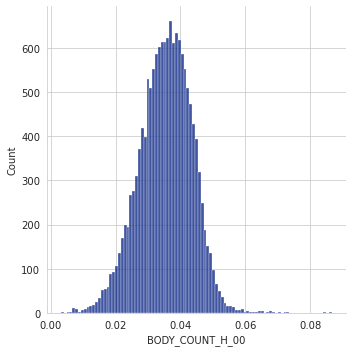

In [20]:
# It's already normalized after creating density dataframe.
sns.displot(density_df.BODY_COUNT_H_00)

In [21]:
model_data = density_df.copy()

## Elbow Method

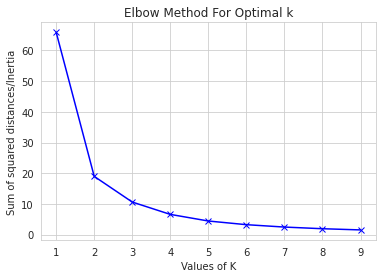

In [22]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(model_data.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [23]:
hrc_model = AgglomerativeClustering(n_clusters=5, linkage='ward', affinity='euclidean')
hrc_preds = hrc_model.fit_predict(model_data)

In [24]:
model_data["cluster"] = hrc_preds

In [25]:
model_data["cluster"].unique()

array([2, 0, 4, 3, 1])

<AxesSubplot:ylabel='cluster'>

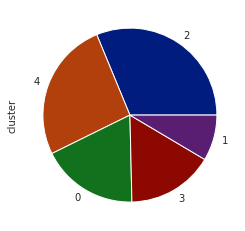

In [26]:
model_data['cluster'].value_counts().plot(kind='pie')

In [136]:
model_data['cluster'].value_counts()

2    4636
4    3869
0    2684
3    2392
1    1265
Name: cluster, dtype: int64

In [27]:
model_data['cluster'].value_counts()

2    4636
4    3869
0    2684
3    2392
1    1265
Name: cluster, dtype: int64

## Decision Points

In [28]:
from sklearn.model_selection import train_test_split

x = model_data.drop('cluster', axis=1)
y = model_data['cluster']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    
dc = DecisionTreeClassifier(criterion="entropy", random_state=42) 
dc.fit(x_train, y_train)
y_pred = dc.predict(x_test)

d_text = tree.export_text(dc)
#print(d_text)

In [29]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.8926530612244898

In [30]:
dc.feature_importances_

array([0.01743943, 0.01967437, 0.04857902, 0.01005594, 0.10668985,
       0.0217019 , 0.01447687, 0.01128569, 0.02230996, 0.01384224,
       0.02443473, 0.09013983, 0.02270818, 0.01006926, 0.0225635 ,
       0.03099614, 0.09072479, 0.4080138 , 0.01429451])

<AxesSubplot:>

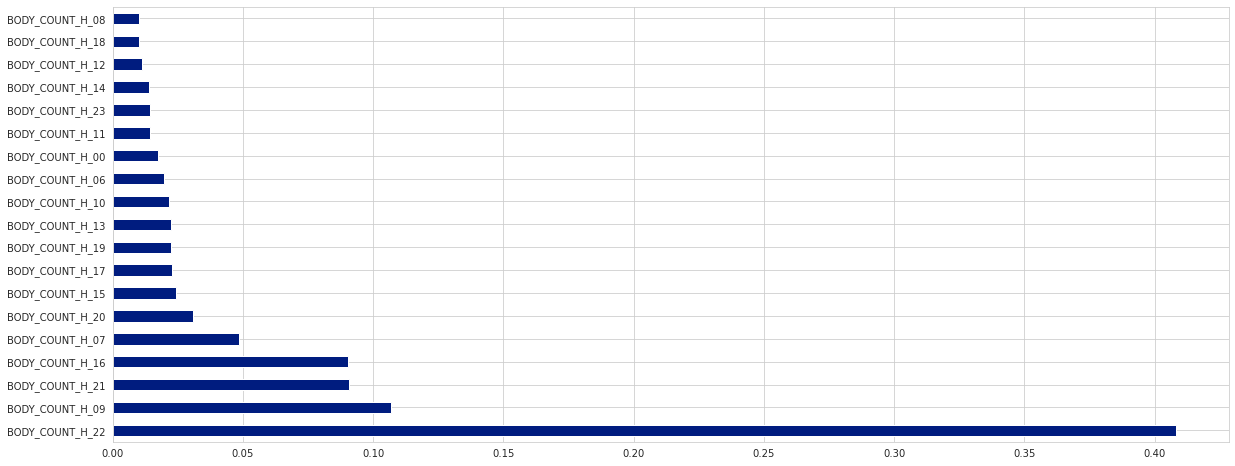

In [172]:
pd.Series(dc.feature_importances_, index=x_train.columns).nlargest(20).plot(kind='barh',figsize=(20, 8))


## Results

----


In [174]:
outlet_dens_df = pd.concat([preds_df, density_df], axis=1)

In [175]:
outlet_dens_df.to_csv("turkcell_hour_cluster.csv")

-----

In [39]:
outlet_list = list(pivot_table.index)

In [41]:
len(outlet_list)

14846

In [40]:
len(hrc_preds)

14846

In [54]:
preds_df = pd.DataFrame(hrc_preds, index = outlet_list, columns =['cluster']).reset_index()
preds_df.rename(columns={'index': 'outlet_number'}, inplace=True)

In [55]:
preds_df

,outlet_number,cluster
0,10006358,2
1,10006376,0
2,10006447,4
3,10006456,2
4,10006518,3
...,...,...
14841,9928176,4
14842,9928188,4
14843,9928190,1
14844,9928206,4


In [115]:
df["CALL_MONTH"] = df["CALL_MONTH"].replace({
'January' :'01_January',
'February' : '02_February',
'March' : '03_March',
'April' : '04_April', 
'May' :  '05_May',
'June' : '06_June' ,
'July' : '07_July',
'August' : '08_August' ,
'September' : '09_September' ,
'October' : '10_October' ,
'November' : '11_November' ,
'December' : '12_December'})

In [116]:
result = pd.merge(preds_df, df, on='outlet_number', how='outer')

In [117]:
result.head()

,outlet_number,cluster,outlet_main_channel_code,main_channel_text,outlet_sub_trade_channel_code,outlet_sub_trade_channel_text,city_name,district_name,neighbor_name,distance,prob,poi_id,poi_name,poi_category,CALL_MONTH,CALL_WEEKDAY,CALL_HOUR,BODY_COUNT
0,10006358,2,1,TRADITIONAL RETAIL,116,GROCERY/MOMP-WALK IN,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,01_January,WEEKEND,H_18,593.400000
1,10006358,2,1,TRADITIONAL RETAIL,116,GROCERY/MOMP-WALK IN,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,01_January,WEEKEND,H_21,566.600000
2,10006358,2,1,TRADITIONAL RETAIL,116,GROCERY/MOMP-WALK IN,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,01_January,WEEKDAY,H_14,733.047619
3,10006358,2,1,TRADITIONAL RETAIL,116,GROCERY/MOMP-WALK IN,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,10_October,WEEKEND,H_13,908.300000
4,10006358,2,1,TRADITIONAL RETAIL,116,GROCERY/MOMP-WALK IN,İstanbul,Pendik,Esenler Mh.,5.702159,0.956893,1957745,Bayar Gıda,Bakkal/Market,03_March,WEEKEND,H_19,861.750000


In [177]:
result.to_csv("turkcell_all_results.csv")

In [118]:
cluster_0 = result.query("cluster == 0")
cluster_1 = result.query("cluster == 1")
cluster_2 = result.query("cluster == 2")
cluster_3 = result.query("cluster == 3")
cluster_4 = result.query("cluster == 4")

<h2><center>General Comparison </center></h2>

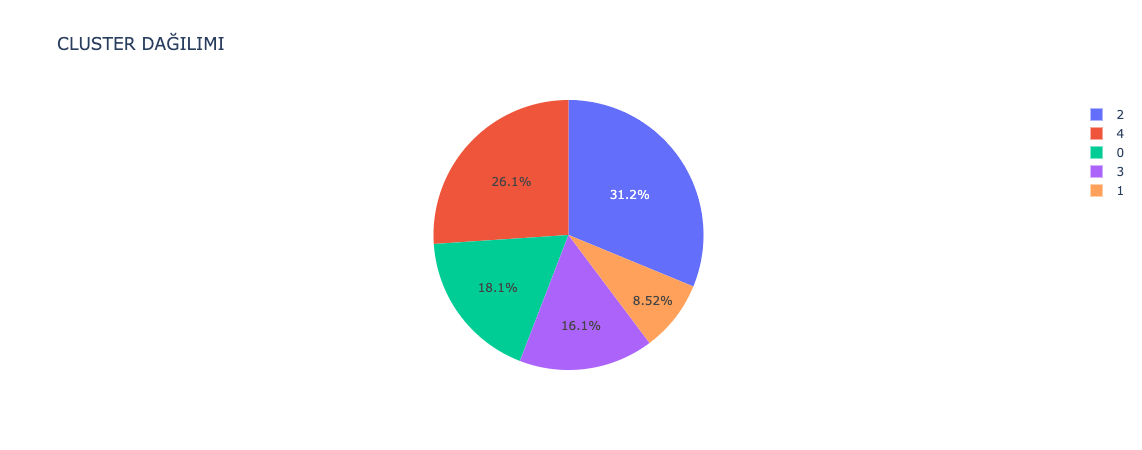

In [147]:
cluster_pie = result.groupby('cluster')['outlet_number'].count().reset_index()

cluster_pie.columns=['cluster','value']
px.pie(cluster_pie, values='value',names='cluster', title="CLUSTER DAĞILIMI")

In [171]:
result.cluster.value_counts()

2    2114016
4    1764264
0    1223904
3    1090752
1     576840
Name: cluster, dtype: int64

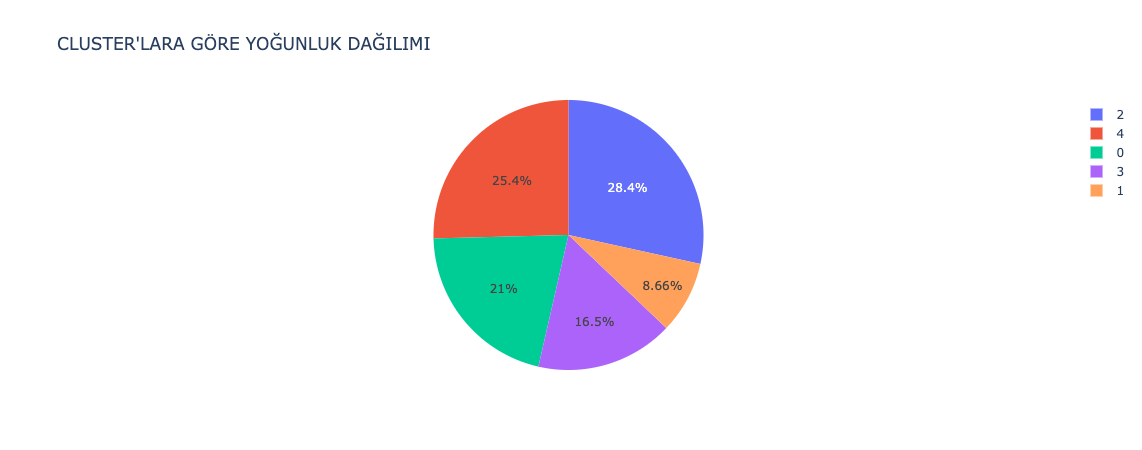

In [134]:
sum_body = result.groupby('cluster')['BODY_COUNT'].sum().reset_index()

sum_body.columns=['cluster','value']
px.pie(sum_body,values='value',names='cluster', title="CLUSTER'LARA GÖRE YOĞUNLUK DAĞILIMI")

<h2><center> Cluster-0 </center></h2>

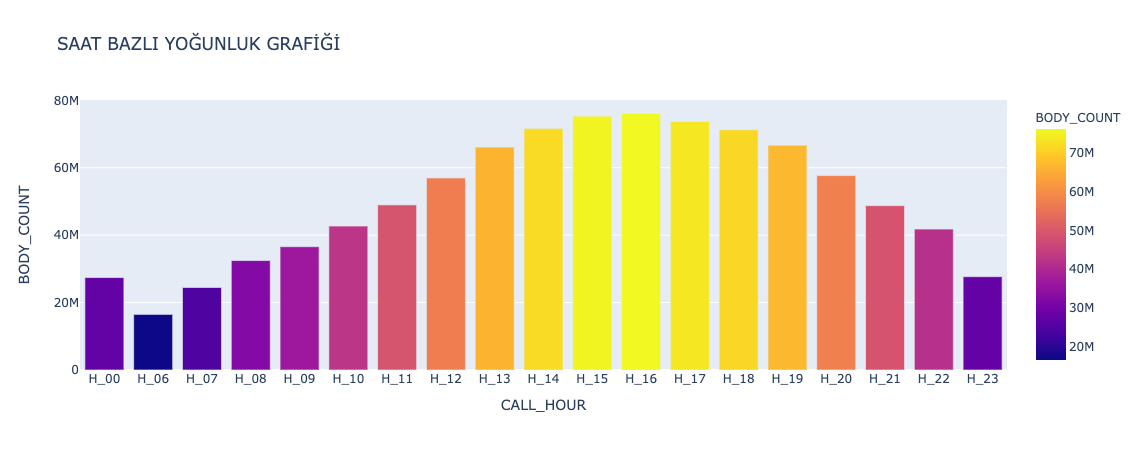

In [120]:
hour_body_0 = cluster_0.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index()

fig = px.bar(hour_body_0, x='CALL_HOUR', y='BODY_COUNT',color="BODY_COUNT",
            title= "SAAT BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

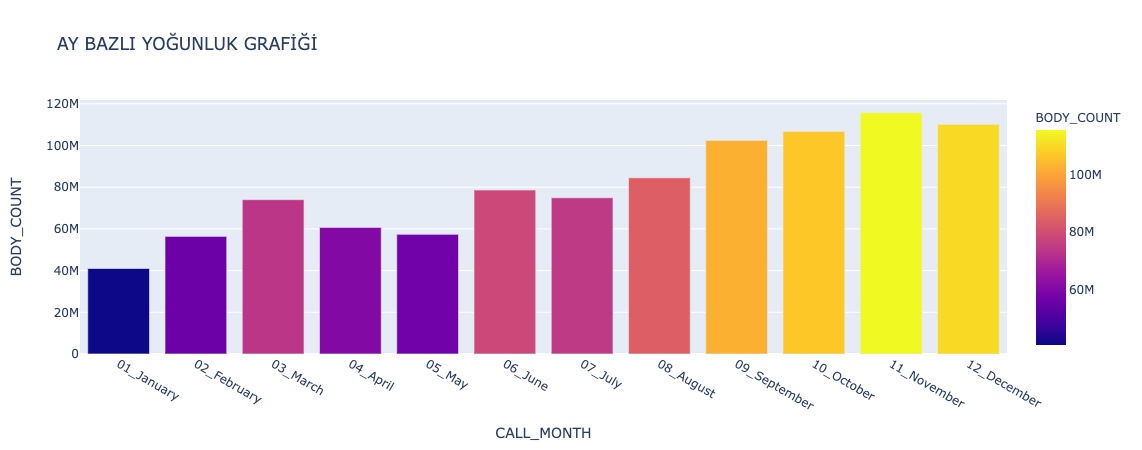

In [122]:
month_body_0 = cluster_0.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index()

fig = px.bar(month_body_0, x='CALL_MONTH', y='BODY_COUNT',color="BODY_COUNT",
            title= "AY BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

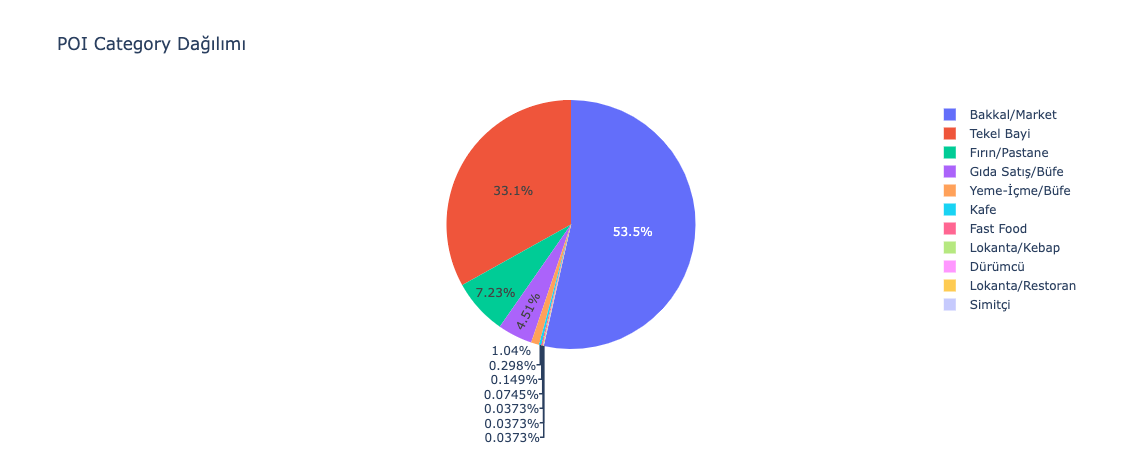

In [126]:
pie=cluster_0.groupby('poi_category').size().reset_index()
pie.columns=['poi_category','value']
px.pie(pie,values='value',names='poi_category', title='POI Category Dağılımı')

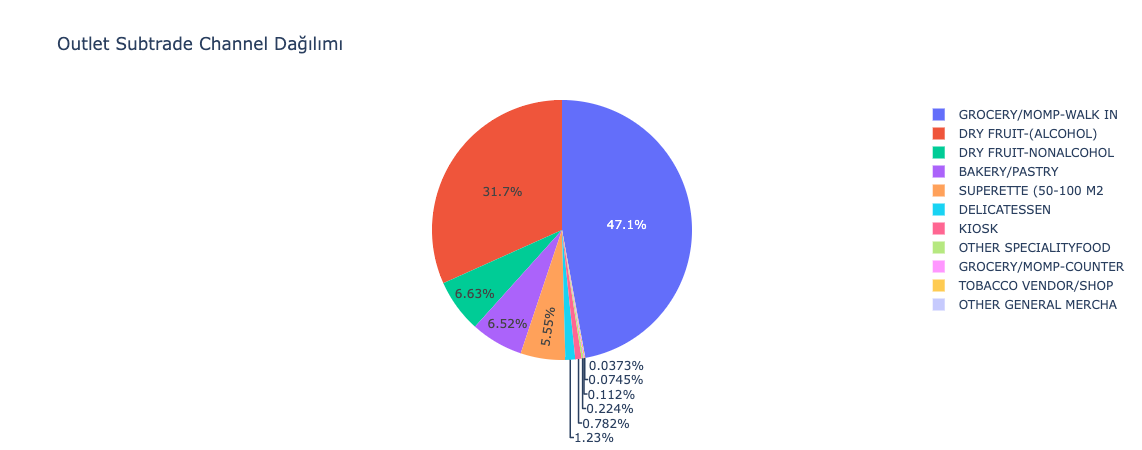

In [125]:
pie=cluster_0.groupby('outlet_sub_trade_channel_text').size().reset_index()
pie.columns=['outlet_sub_trade_channel_text','value']
px.pie(pie,values='value',names='outlet_sub_trade_channel_text', title='Outlet Subtrade Channel Dağılımı')

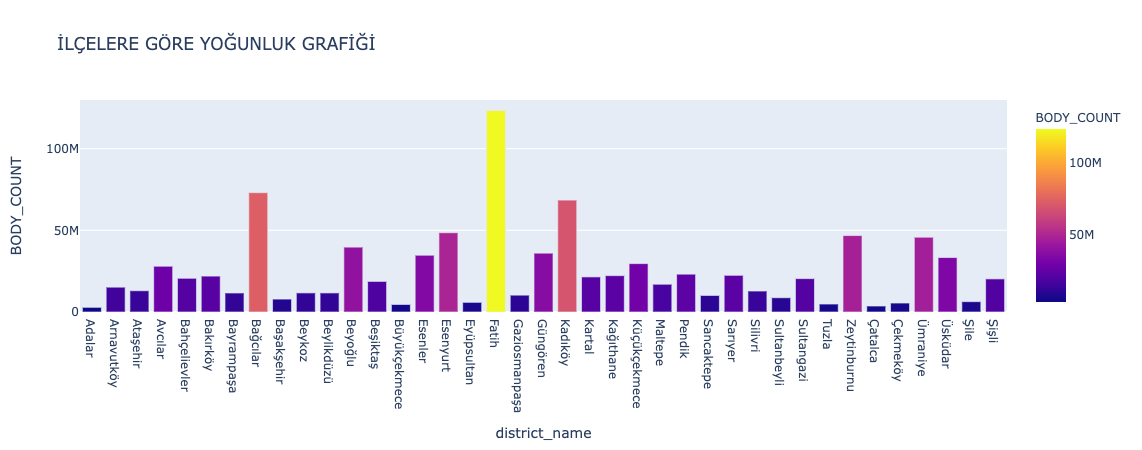

In [128]:
dist_body_0 = cluster_0.groupby('district_name')['BODY_COUNT'].sum().reset_index()

fig = px.bar(dist_body_0, x='district_name', y='BODY_COUNT',color="BODY_COUNT",
            title= "İLÇELERE GÖRE YOĞUNLUK GRAFİĞİ")
fig.show()

<h2><center> Cluster-1 </center></h2>

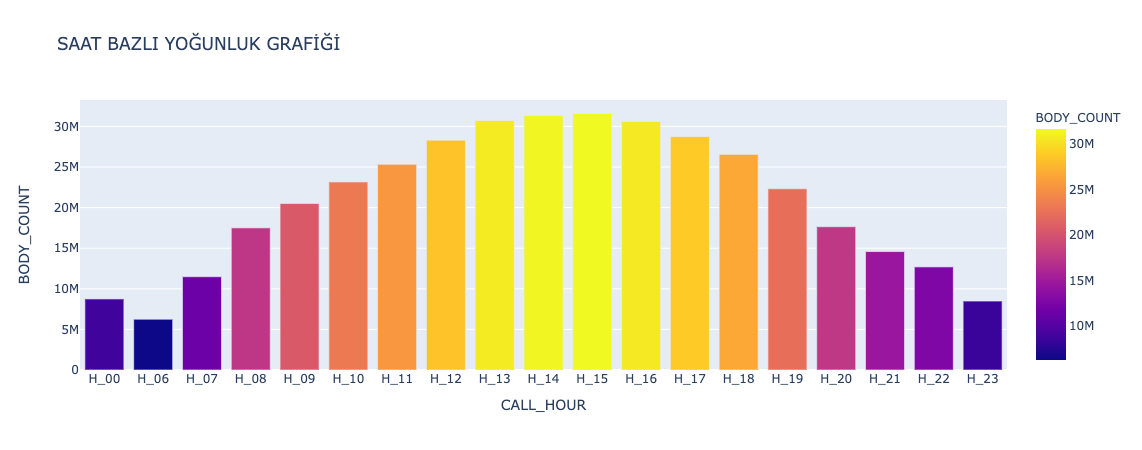

In [148]:
hour_body_1 = cluster_1.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index()

fig = px.bar(hour_body_1, x='CALL_HOUR', y='BODY_COUNT',color="BODY_COUNT",
            title= "SAAT BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

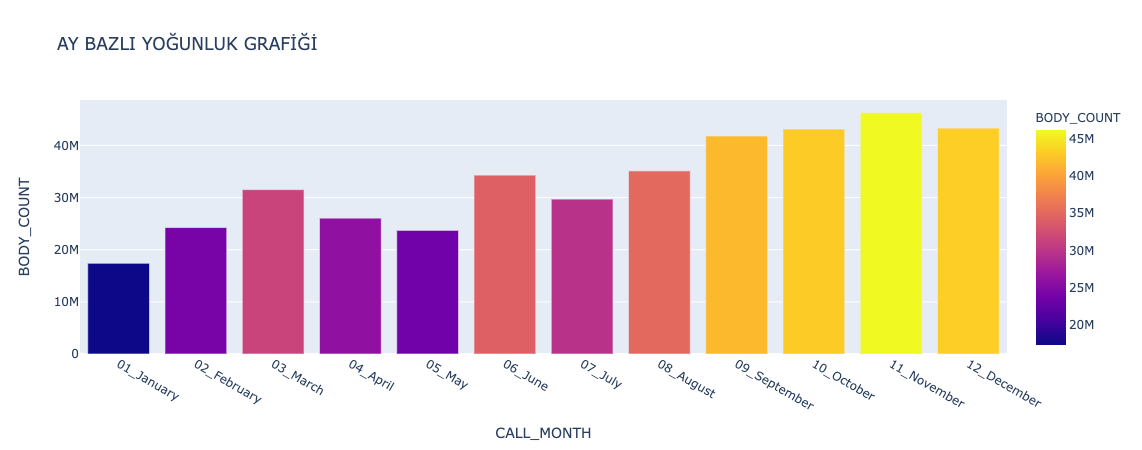

In [150]:
month_body_1 = cluster_1.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index()

fig = px.bar(month_body_1, x='CALL_MONTH', y='BODY_COUNT',color="BODY_COUNT",
            title= "AY BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

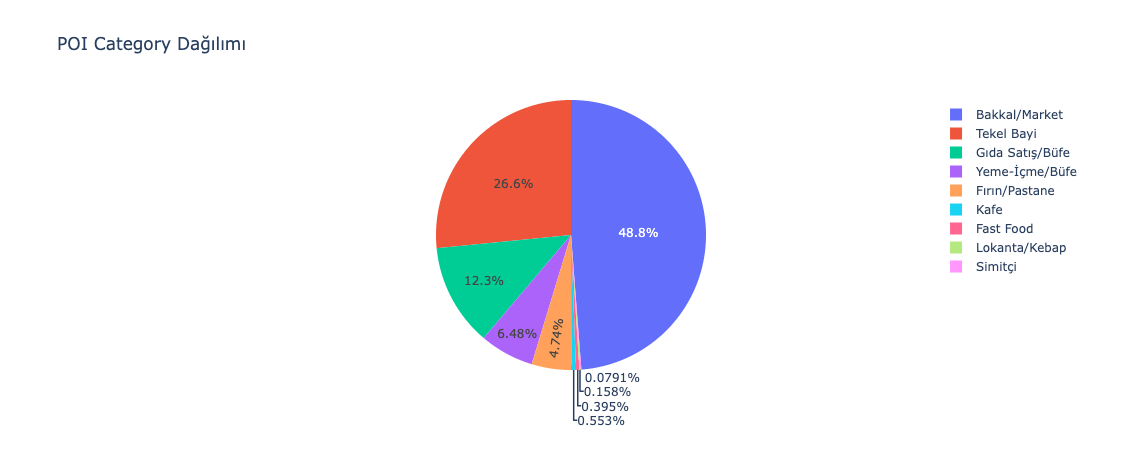

In [151]:
pie=cluster_1.groupby('poi_category').size().reset_index()
pie.columns=['poi_category','value']
px.pie(pie,values='value',names='poi_category', title='POI Category Dağılımı')

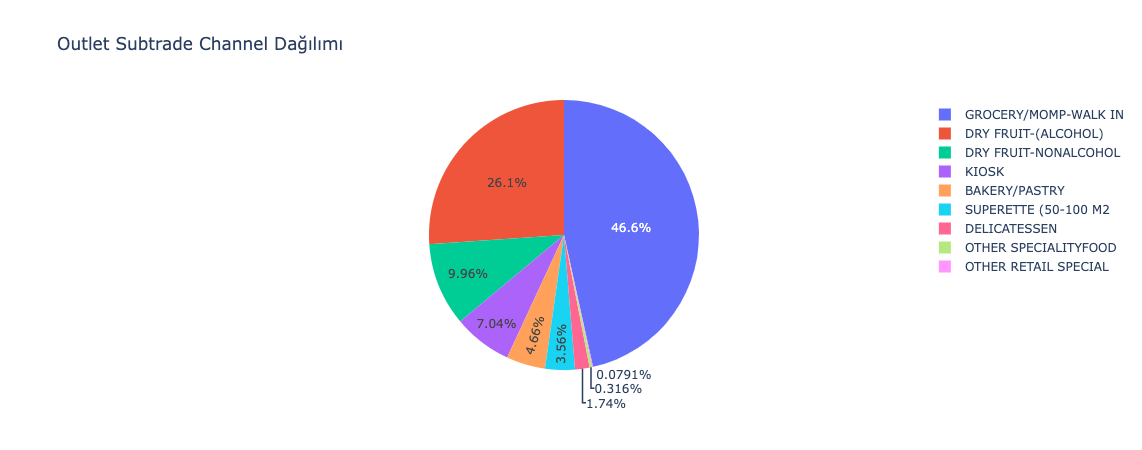

In [152]:
pie=cluster_1.groupby('outlet_sub_trade_channel_text').size().reset_index()
pie.columns=['outlet_sub_trade_channel_text','value']
px.pie(pie,values='value',names='outlet_sub_trade_channel_text', title='Outlet Subtrade Channel Dağılımı')

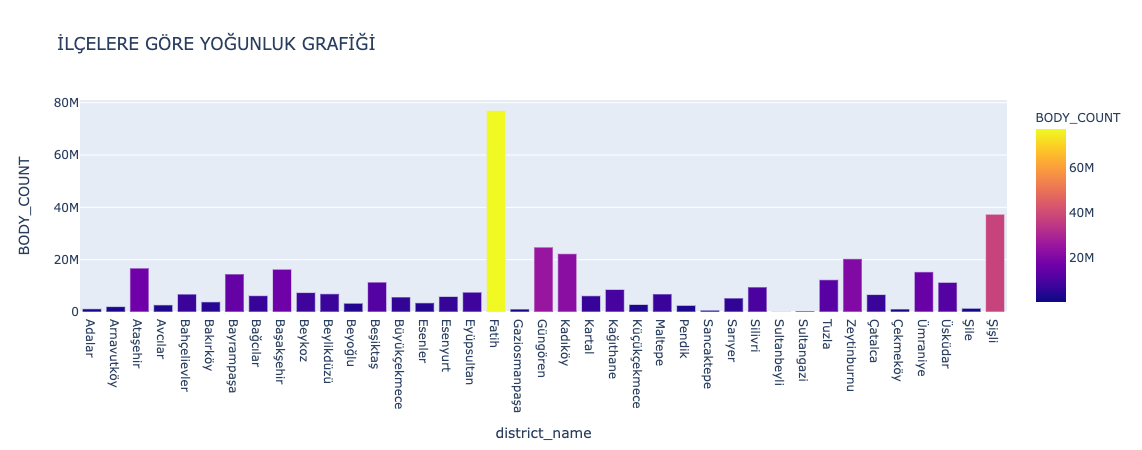

In [153]:
dist_body_1 = cluster_1.groupby('district_name')['BODY_COUNT'].sum().reset_index()

fig = px.bar(dist_body_1, x='district_name', y='BODY_COUNT',color="BODY_COUNT",
            title= "İLÇELERE GÖRE YOĞUNLUK GRAFİĞİ")
fig.show()

<h2><center> Cluster-2 </center></h2>

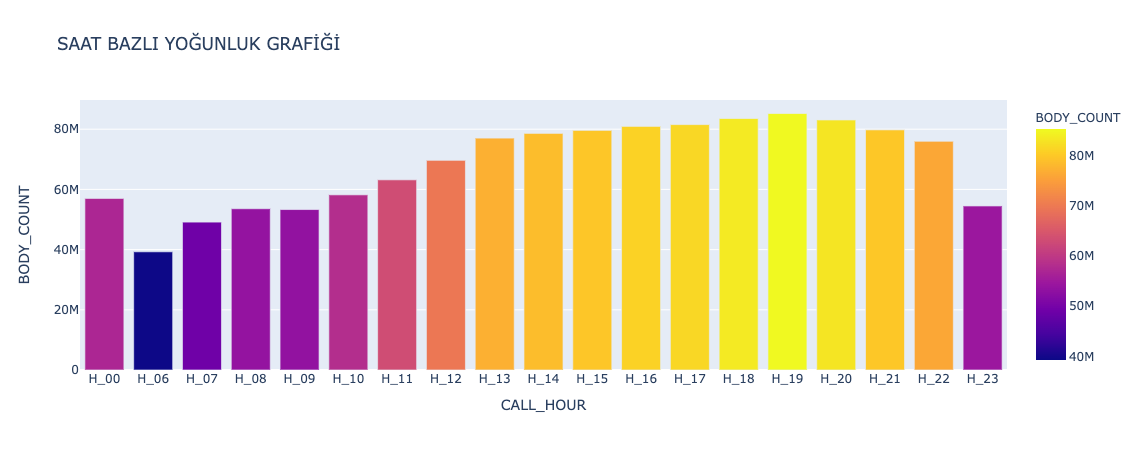

In [154]:
hour_body_2 = cluster_2.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index()

fig = px.bar(hour_body_2, x='CALL_HOUR', y='BODY_COUNT',color="BODY_COUNT",
            title= "SAAT BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

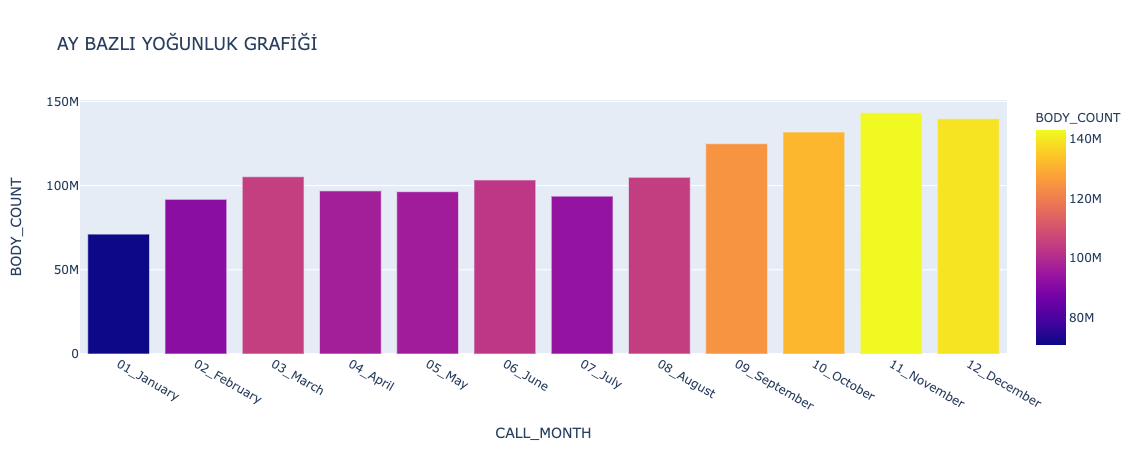

In [155]:
month_body_2 = cluster_2.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index()

fig = px.bar(month_body_2, x='CALL_MONTH', y='BODY_COUNT',color="BODY_COUNT",
            title= "AY BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

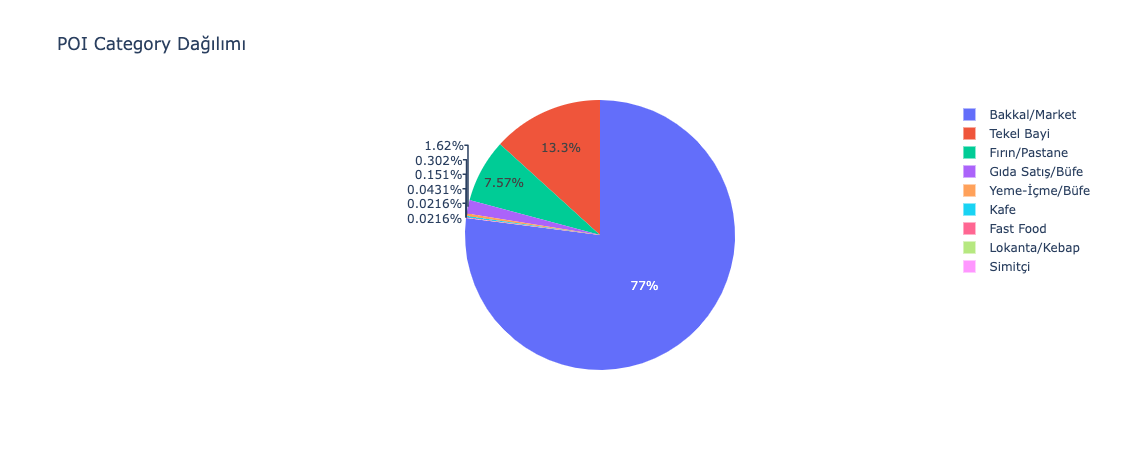

In [156]:
pie=cluster_2.groupby('poi_category').size().reset_index()
pie.columns=['poi_category','value']
px.pie(pie,values='value',names='poi_category', title='POI Category Dağılımı')

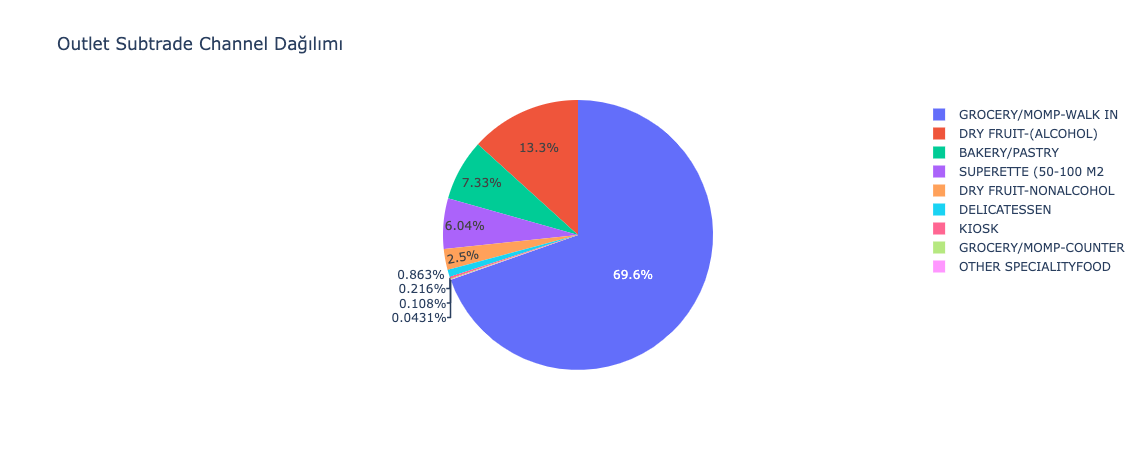

In [157]:
pie=cluster_2.groupby('outlet_sub_trade_channel_text').size().reset_index()
pie.columns=['outlet_sub_trade_channel_text','value']
px.pie(pie,values='value',names='outlet_sub_trade_channel_text', title='Outlet Subtrade Channel Dağılımı')

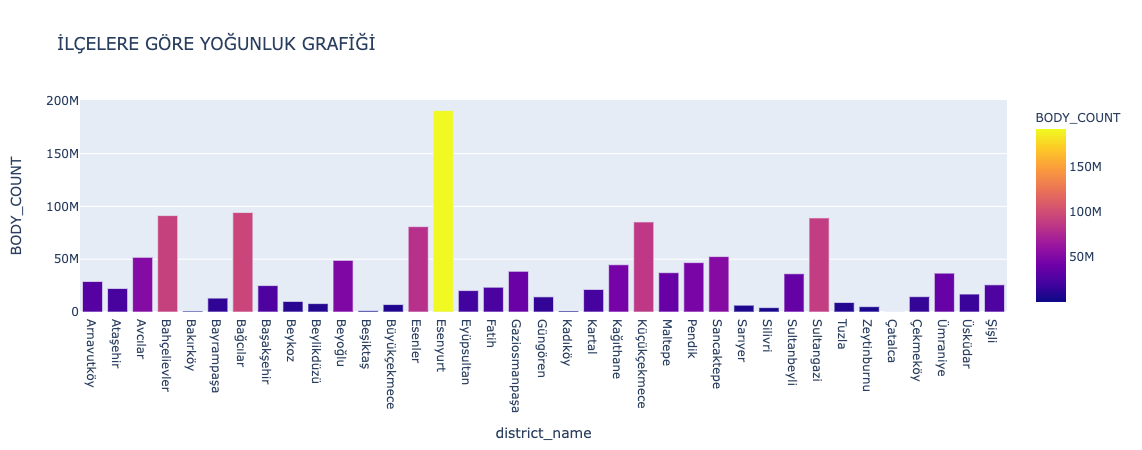

In [158]:
dist_body_2 = cluster_2.groupby('district_name')['BODY_COUNT'].sum().reset_index()

fig = px.bar(dist_body_2, x='district_name', y='BODY_COUNT',color="BODY_COUNT",
            title= "İLÇELERE GÖRE YOĞUNLUK GRAFİĞİ")
fig.show()

<h2><center> Cluster-3 </center></h2>

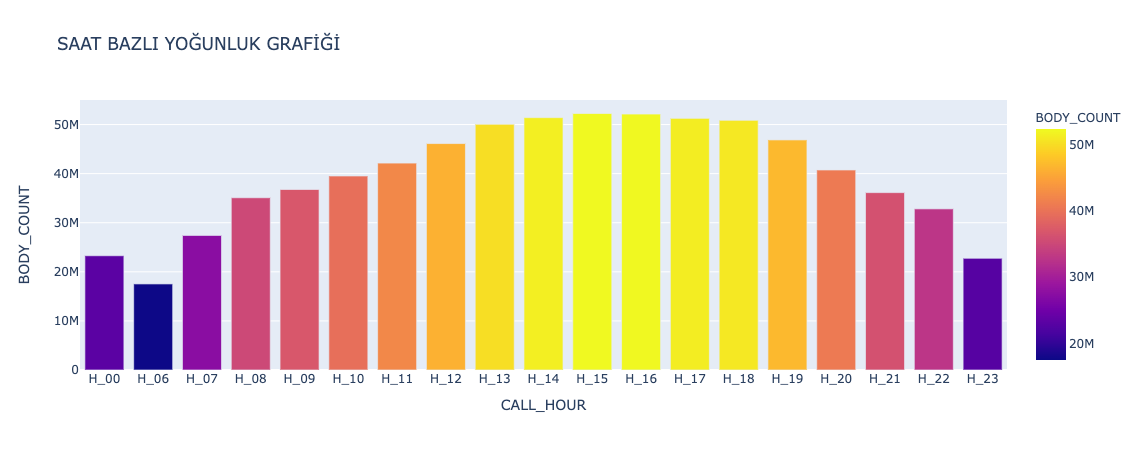

In [159]:
hour_body_3 = cluster_3.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index()

fig = px.bar(hour_body_3, x='CALL_HOUR', y='BODY_COUNT',color="BODY_COUNT",
            title= "SAAT BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

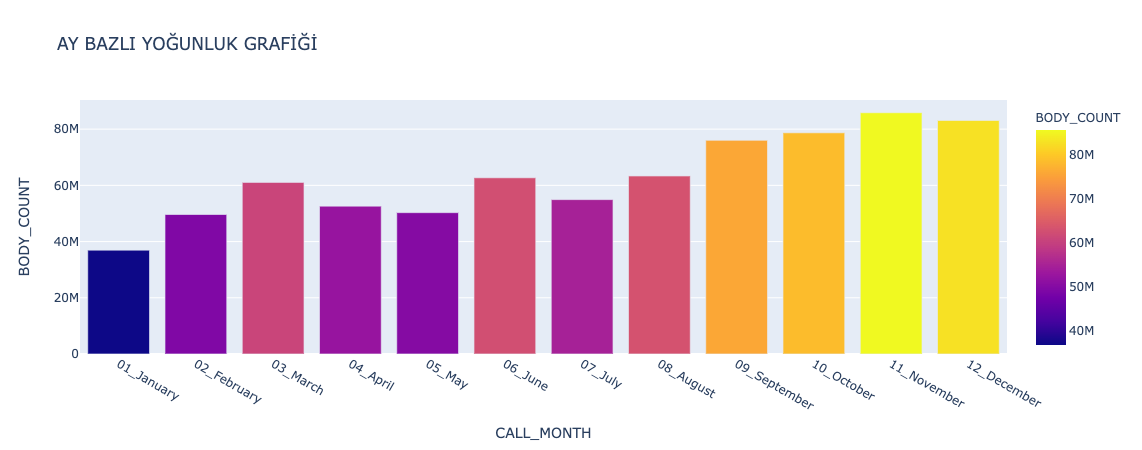

In [160]:
month_body_3 = cluster_3.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index()

fig = px.bar(month_body_3, x='CALL_MONTH', y='BODY_COUNT',color="BODY_COUNT",
            title= "AY BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

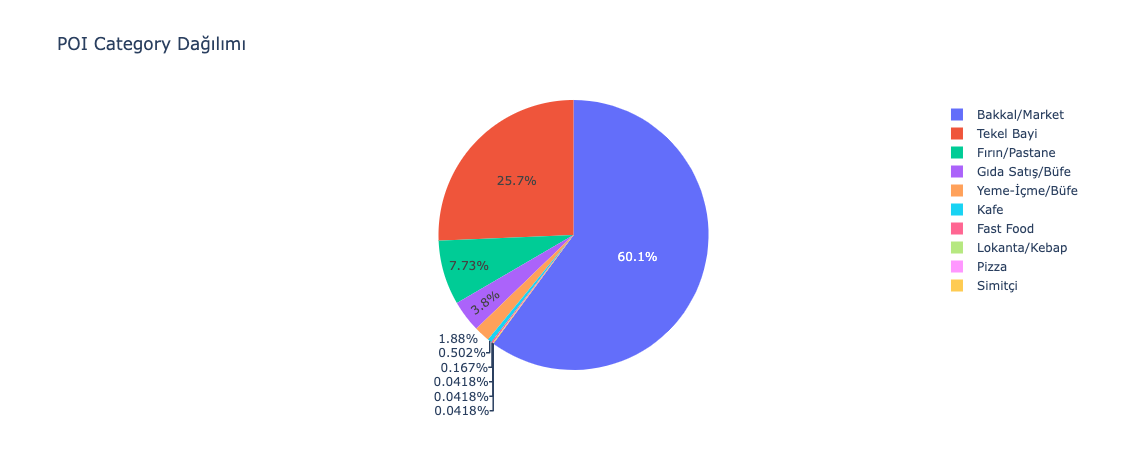

In [161]:
pie=cluster_3.groupby('poi_category').size().reset_index()
pie.columns=['poi_category','value']
px.pie(pie,values='value',names='poi_category', title='POI Category Dağılımı')

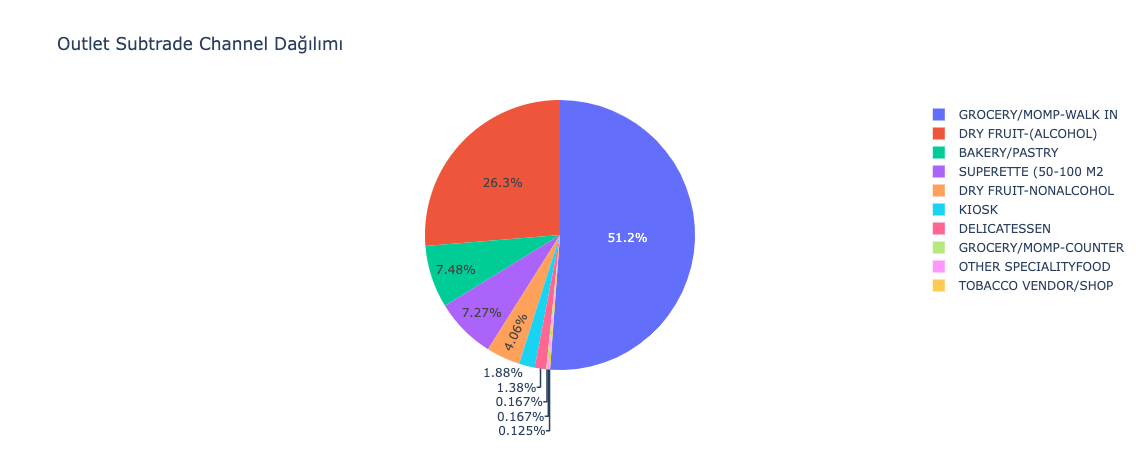

In [162]:
pie=cluster_3.groupby('outlet_sub_trade_channel_text').size().reset_index()
pie.columns=['outlet_sub_trade_channel_text','value']
px.pie(pie,values='value',names='outlet_sub_trade_channel_text', title='Outlet Subtrade Channel Dağılımı')

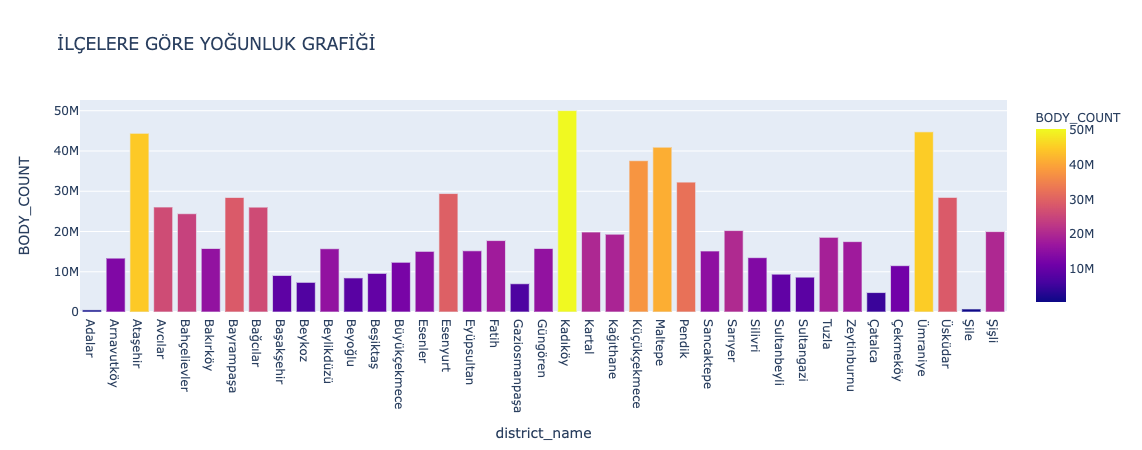

In [163]:
dist_body_3 = cluster_3.groupby('district_name')['BODY_COUNT'].sum().reset_index()

fig = px.bar(dist_body_3, x='district_name', y='BODY_COUNT',color="BODY_COUNT",
            title= "İLÇELERE GÖRE YOĞUNLUK GRAFİĞİ")
fig.show()

<h2><center> Cluster-4 </center></h2>

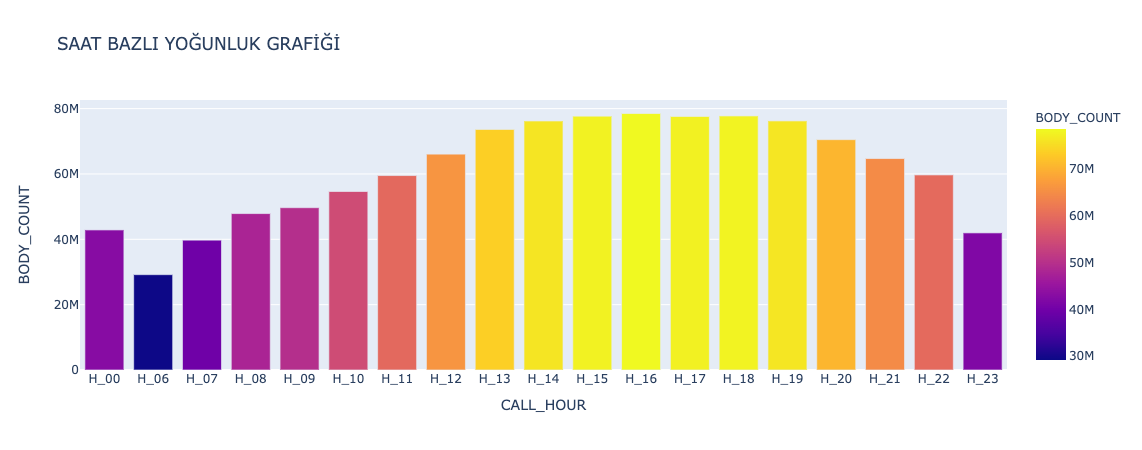

In [164]:
hour_body_4 = cluster_4.groupby('CALL_HOUR')['BODY_COUNT'].sum().reset_index()

fig = px.bar(hour_body_4, x='CALL_HOUR', y='BODY_COUNT',color="BODY_COUNT",
            title= "SAAT BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

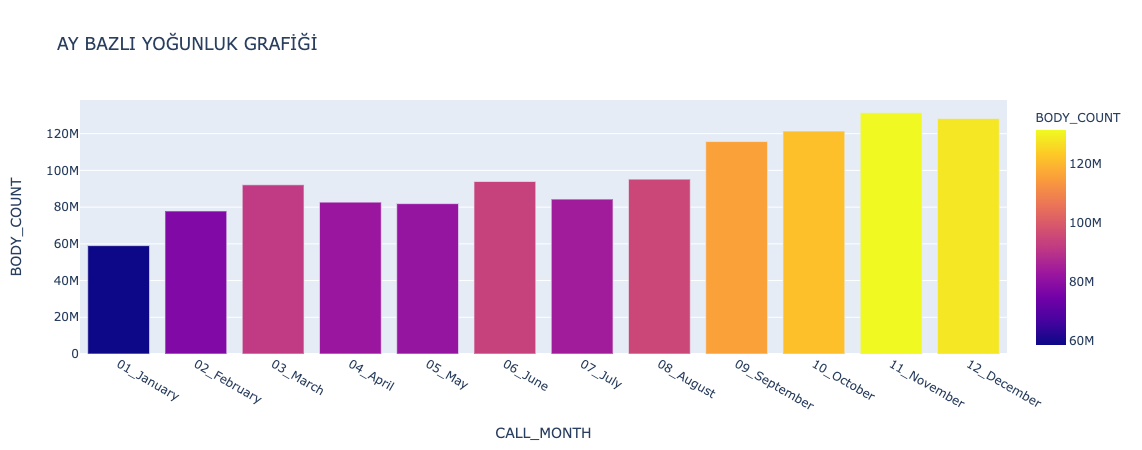

In [165]:
month_body_4 = cluster_4.groupby('CALL_MONTH')['BODY_COUNT'].sum().reset_index()

fig = px.bar(month_body_4, x='CALL_MONTH', y='BODY_COUNT',color="BODY_COUNT",
            title= "AY BAZLI YOĞUNLUK GRAFİĞİ")
fig.show()

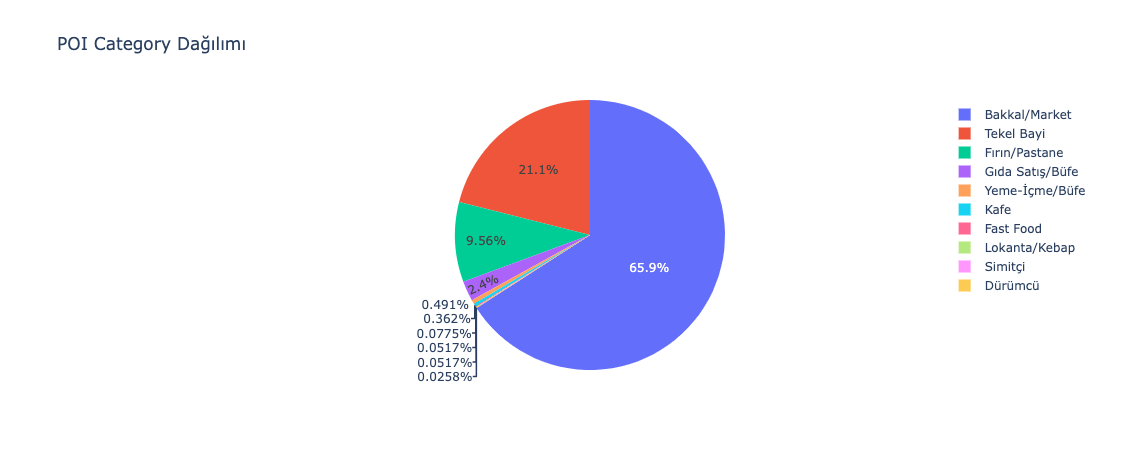

In [166]:
pie=cluster_4.groupby('poi_category').size().reset_index()
pie.columns=['poi_category','value']
px.pie(pie,values='value',names='poi_category', title='POI Category Dağılımı')

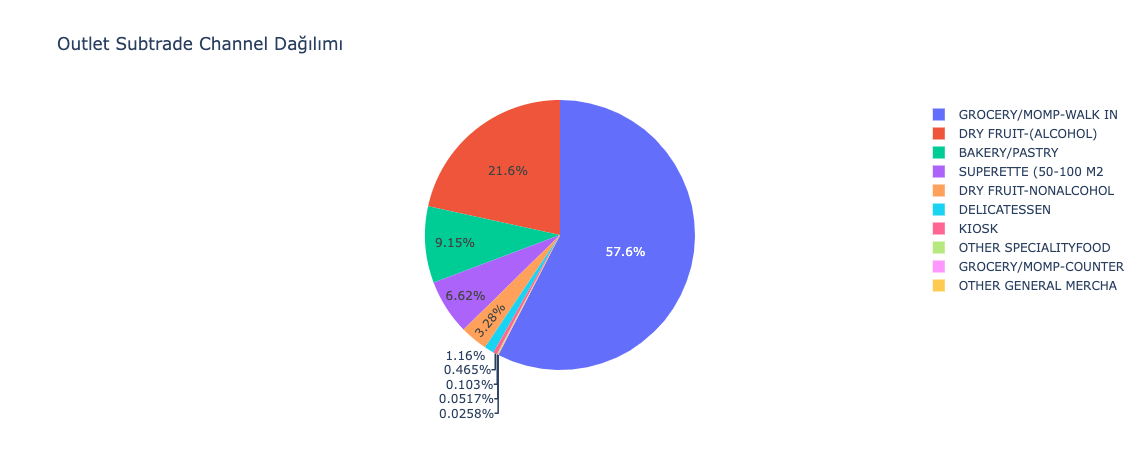

In [167]:
pie=cluster_4.groupby('outlet_sub_trade_channel_text').size().reset_index()
pie.columns=['outlet_sub_trade_channel_text','value']
px.pie(pie,values='value',names='outlet_sub_trade_channel_text', title='Outlet Subtrade Channel Dağılımı')

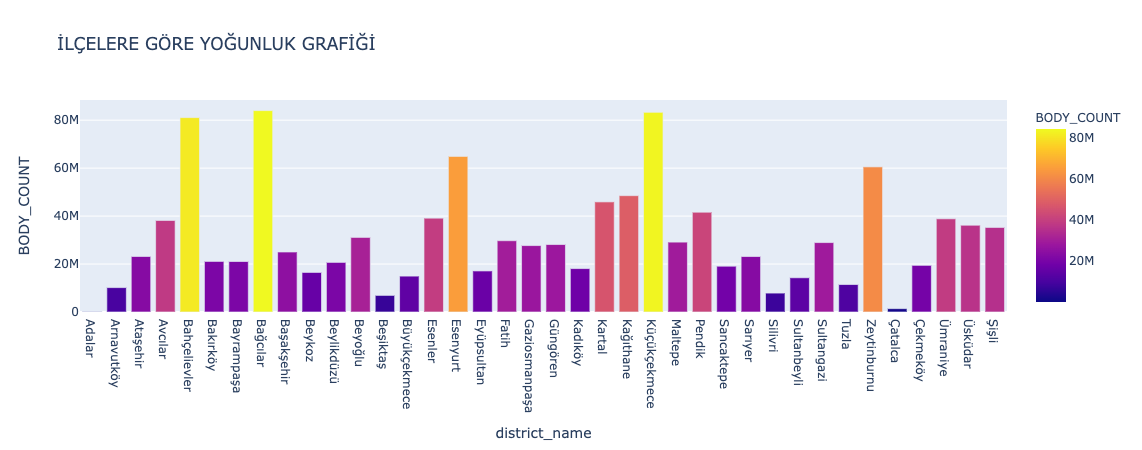

In [168]:
dist_body_4 = cluster_4.groupby('district_name')['BODY_COUNT'].sum().reset_index()

fig = px.bar(dist_body_4, x='district_name', y='BODY_COUNT',color="BODY_COUNT",
            title= "İLÇELERE GÖRE YOĞUNLUK GRAFİĞİ")
fig.show()